*Created by Petteri Nevavuori (<petteri.nevavuori@gmail.com>)*

---
# Appendix A. Assessing the Models

In this notebook we will ~~train our model once more with the hyperparamers~~ generate outputs for our best performing models found during the optimization process. We will also visualize how our trained model's output matches to the real target values.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-Models" data-toc-modified-id="Loading-the-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the Models</a></span></li><li><span><a href="#Initializing-Datasets" data-toc-modified-id="Initializing-Datasets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initializing Datasets</a></span></li><li><span><a href="#Producing-CSVs" data-toc-modified-id="Producing-CSVs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Producing CSVs</a></span></li><li><span><a href="#Visualizing-the-Data" data-toc-modified-id="Visualizing-the-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualizing the Data</a></span></li></ul></div>

## Loading the Models

First we load the final models.

In [3]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from field_analysis.model.nets.cnn import DroneYieldMeanCNN
import field_analysis.model.dataset.dataperiod as dp

models_dir = os.path.join(os.getcwd(),'models')

print('Loading DroneYieldMeanCNN for Earlier RGB')

earlier_model_name = '20181211_125749864_Adadelta_3x128x128_6cnn_2fc.pkl'
earlier_model_path = os.path.join(models_dir,earlier_model_name)
cnn_earlier = DroneYieldMeanCNN(source_bands=3,source_dim=128,cnn_layers=6)
cnn_earlier.model_filename = earlier_model_name
cnn_earlier.model_path = earlier_model_path
cnn_earlier.load_model()

print('Loading DroneYieldMeanCNN for Later RGB')

later_model_name = '20181212_015347366_Adadelta_3x128x128_6cnn_2fc.pkl'
later_model_path = os.path.join(models_dir,later_model_name)
cnn_later = DroneYieldMeanCNN(source_bands=3,source_dim=128,cnn_layers=6)
cnn_later.model_filename = later_model_name
cnn_later.model_path = later_model_path
cnn_later.load_model()

Loading DroneYieldMeanCNN for Earlier RGB
Reading the model from /home/nevavuor/crop-field-cnn/models/20181211_125749864_Adadelta_3x128x128_6cnn_2fc.pkl
Loading DroneYieldMeanCNN for Later RGB
Reading the model from /home/nevavuor/crop-field-cnn/models/20181212_015347366_Adadelta_3x128x128_6cnn_2fc.pkl


## Initializing Datasets

Next we will initialize custom datasets for building up CSV-files with output-target value pairs and their corresponding field block ID and image acquisition date. The ``peewee`` queries are almost directly copied from the source code with some additions.

In [4]:
import os
import datetime

from field_analysis.db.models import Area, DataPeriod, Target, initialize_db
from field_analysis.settings import model as model_settings

DATE_DIVIDER = datetime.date(2017, 7, 1)
DB_128 = 'field_analysis_40m_128px.db'
initialize_db(os.path.join(model_settings.DATABASES_DIR, DB_128))

dataperiods_earlier = (DataPeriod
                        .select(DataPeriod.id,
                                DataPeriod.date,
                                DataPeriod.area_drone_rgb,
                                Area.id,
                                Area.block_id,
                                Target.area_yield)
                        .join(Area)
                        .join(Target)
                        .where(
                            (DataPeriod.area_drone_rgb.is_null(False)) &
                            (DataPeriod.date < DATE_DIVIDER) &
                            (Area.block_id != 8860095891) &
                            (Target.area_yield.is_null(False))))
dataperiods_later = (DataPeriod
                        .select(DataPeriod.id,
                                DataPeriod.date,
                                DataPeriod.area_drone_rgb,
                                Area.id,
                                Area.block_id,
                                Target.area_yield)
                        .join(Area)
                        .join(Target)
                        .where(
                            (DataPeriod.area_drone_rgb.is_null(False)) &
                            (DataPeriod.date >= DATE_DIVIDER) &
                            (Area.block_id != 8860095891) &
                            (Target.area_yield.is_null(False))))

## Producing CSVs

Then we'll go through our datasets and persist the relevant information.

In [7]:
import pickle
from field_analysis.model.dataset.dataperiod import DataPeriodDataset

def produce_output(cnn, dataperiods,period):
    y_trues, y_preds, block_ids, dates = [],[],[],[]
    with torch.set_grad_enabled(False):
        for dataperiod in dataperiods:
            x = DataPeriodDataset().array_to_tensor(pickle.loads(dataperiod.area_drone_rgb))
            y = DataPeriodDataset().array_to_tensor(pickle.loads(dataperiod.area.target.area_yield)).mean()
            block_id = dataperiod.area.block_id
            date = dataperiod.date.strftime("%Y-%m-%d")
            
            y_trues.append(y.item())
            y_preds.append(cnn(x.unsqueeze(0).float().cuda()).item())
            block_ids.append(block_id)
            dates.append(date)

    df = pd.DataFrame(columns=['y_true','y_pred','block_id','date'])
    df.loc[:,'y_true'] = y_trues
    df.loc[:,'y_pred'] = y_preds
    df.loc[:,'block_id'] = block_ids
    df.loc[:,'date'] = dates
    df.to_csv(os.path.join(os.getcwd(),'results',f'targets_predictions_blocks_dates_{period}.csv'))
    return df

In [8]:
out_earlier = produce_output(cnn_earlier, dataperiods_earlier,'earlier')
out_later = produce_output(cnn_later, dataperiods_later,'later')

## Visualizing the Data

The last thing is to visualize our data.

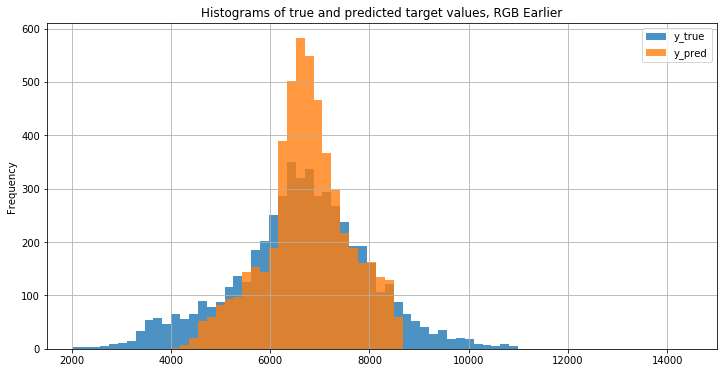

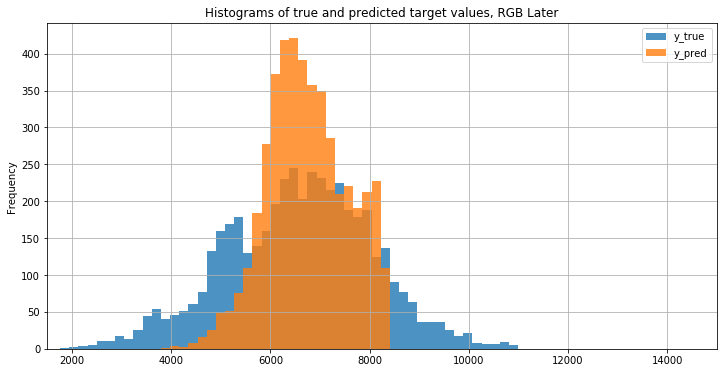

In [12]:
out_earlier[['y_true','y_pred']].plot.hist(
    figsize=(12,6),grid=True,bins=50,alpha=0.8,xlim=(1500,15000),
    title='Histograms of true and predicted target values, RGB Earlier')
out_later[['y_true','y_pred']].plot.hist(
    figsize=(12,6),grid=True,bins=50,alpha=0.8,xlim=(1500,15000),
    title='Histograms of true and predicted target values, RGB Later')

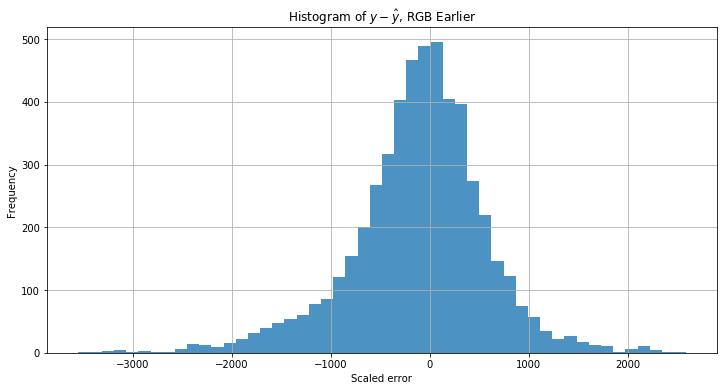

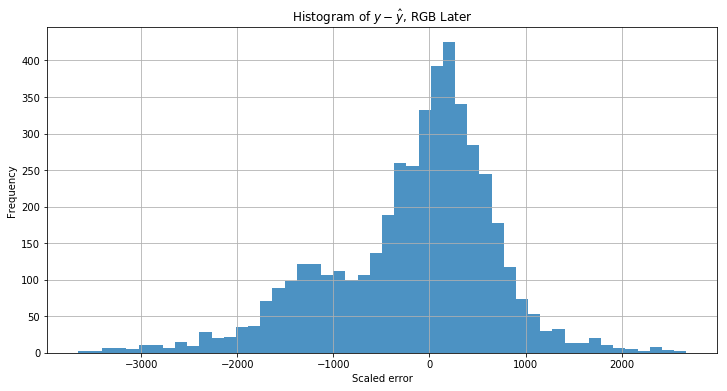

In [13]:
(out_earlier.y_true-out_earlier.y_pred).plot(
    kind='hist',figsize=(12,6),grid=True,bins=50,alpha=0.8,
    title='Histogram of $y-\hat{y}$, RGB Earlier')
plt.xlabel('Scaled error')
plt.show()

(out_later.y_true-out_later.y_pred).plot(
    kind='hist',figsize=(12,6),grid=True,bins=50,alpha=0.8,
    title='Histogram of $y-\hat{y}$, RGB Later')
plt.xlabel('Scaled error')
plt.show()

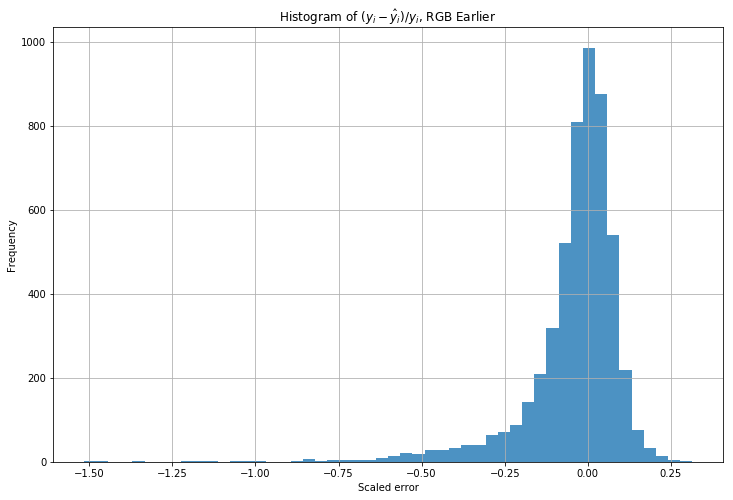

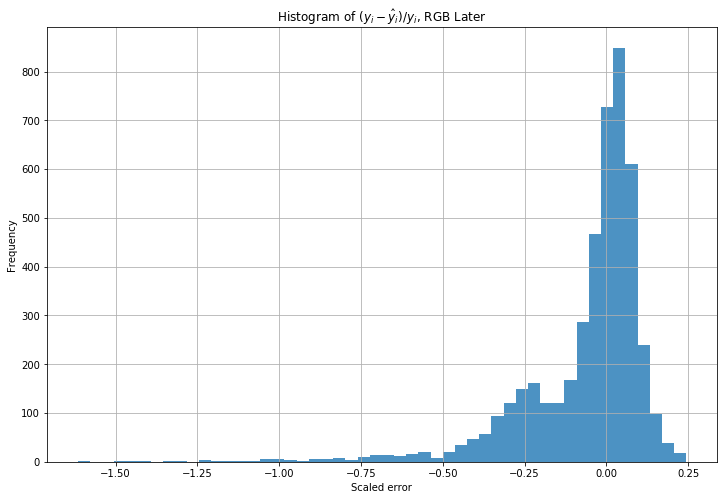

In [14]:
((out_earlier.y_true-out_earlier.y_pred)/out_earlier.y_true).plot(
    kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,
    title='Histogram of $(y_i-\hat{y}_i)/y_i$, RGB Earlier')
plt.xlabel('Scaled error')
plt.show()

((out_later.y_true-out_later.y_pred)/out_later.y_true).plot(
    kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,
    title='Histogram of $(y_i-\hat{y}_i)/y_i$, RGB Later')
plt.xlabel('Scaled error')
plt.show()